## Deep Learning for Mortality Prediction (DLMP)

### Import packages 

In [228]:
import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
tfkl = tf.keras.layers

### Prepare data

In [229]:
# loading in USMDB data
data = []
ages = []
states = []
genders = []

with open("../data/usmdb/usmdb.csv", "r") as file:
    reader = csv.reader(file,delimiter=',')
    for row_index, row in enumerate(reader):
        if row_index == 0:
            print(row)
        if row_index >= 1:
            state, gender, year, age, rate = row
            year = int(year)
            try:
                age = int(age)
            except:
                age = -1
            if state not in states:
                states.append(state)
            state = states.index(state)
            if gender not in genders:
                genders.append(gender)
            gender = genders.index(gender)
            try:
                rate = float(rate)
            except:
                rate = -1
            if rate > 1:
                rate = 1
            # get rid of years, ages, not in health data and other cleaning
            if age != -1 and rate != -1 and age <= 99:
                data.append([state, gender, year, age, rate])

state_data = np.array(data)

['PopName', 'Sex', 'Year', 'Age', 'mx']


In [306]:
print(states)

['AK', 'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']


In [230]:
# loading in HMD data
data = []
ages = []
countries = []
genders = []

with open("../data/hmd.csv", "r") as file:
    reader = csv.reader(file,delimiter=",")
    for row_index, row in enumerate(reader):
        if row_index == 0:
            print(row)
        if row_index >= 1:
            country, gender, year, age, rate = row
            year = int(year)
            try:
                age = int(age)
            except:
                age = -1
            if country not in countries:
                countries.append(country)
            country = countries.index(country)
            if gender not in genders:
                genders.append(gender)
            gender = genders.index(gender)
            try:
                rate = float(rate)
            except:
                rate = -1
            if rate > 1:
                rate = 1
            if age != -1 and rate != -1 and age <= 99:
                data.append([country, gender, year, age, rate])

country_data = np.array(data)

# getting unique values for geographic location column 
country_data[:,0] = country_data[:,0] + 50

['Country', 'Gender', 'Year', 'Age', 'Mortality_rate']


In [307]:
print(countries)

['AUS', 'AUT', 'BEL', 'BGR', 'BLR', 'CAN', 'CHE', 'CZE', 'DNK', 'ESP', 'EST', 'FIN', 'FRATNP', 'GBRTENW', 'GBR_NIR', 'GBR_SCO', 'GRC', 'HUN', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'LTU', 'LUX', 'LVA', 'NLD', 'NOR', 'NZL_NM', 'POL', 'PRT', 'RUS', 'SVK', 'SVN', 'SWE', 'TWN', 'UKR', 'USA']


In [317]:
geos_list = states + countries
geos_index = np.arange(88)
geos_key = np.column_stack((np.array(geos_list), geos_index))
geos_key

array([['AK', '0'],
       ['AL', '1'],
       ['AZ', '2'],
       ['AR', '3'],
       ['CA', '4'],
       ['CO', '5'],
       ['CT', '6'],
       ['DE', '7'],
       ['FL', '8'],
       ['GA', '9'],
       ['HI', '10'],
       ['ID', '11'],
       ['IL', '12'],
       ['IN', '13'],
       ['IA', '14'],
       ['KS', '15'],
       ['KY', '16'],
       ['LA', '17'],
       ['ME', '18'],
       ['MD', '19'],
       ['MA', '20'],
       ['MI', '21'],
       ['MN', '22'],
       ['MS', '23'],
       ['MO', '24'],
       ['MT', '25'],
       ['NE', '26'],
       ['NV', '27'],
       ['NH', '28'],
       ['NJ', '29'],
       ['NM', '30'],
       ['NY', '31'],
       ['NC', '32'],
       ['ND', '33'],
       ['OH', '34'],
       ['OK', '35'],
       ['OR', '36'],
       ['PA', '37'],
       ['RI', '38'],
       ['SC', '39'],
       ['SD', '40'],
       ['TN', '41'],
       ['TX', '42'],
       ['UT', '43'],
       ['VT', '44'],
       ['VA', '45'],
       ['WA', '46'],
       ['WV', '47'],
  

### Set up functions to be used throughout analysis

In [231]:
def get_data(index, data, max_val, mode):
    if mode == "train":
        # Randomly selects index from training data between 0 and the max index in train
        rand_index = tf.random.uniform([], minval=0, maxval=max_val, dtype=tf.int32) 
        entry = data[rand_index, :]
    elif mode == "not_random":
        # Selects specified index from test data 
        entry = data[index, :]
    else:  # Assuming mode="test" or any other value
        # For any other value of mode, randomly selects index from test
        rand_index = tf.random.uniform([], minval=0, maxval=max_val, dtype=tf.int32)
        entry = data[rand_index, :]

    geography, gender, year, age, rate = entry[0], entry[1], entry[2], entry[3], entry[4]

    # Normalization
    year = (year - 1959) / 60
    age = tf.cast(age, tf.int32)
    geography = tf.cast(geography, tf.int32)
    gender = tf.cast(gender, tf.int32)

    # Reshape each element to scalar
    features = (tf.reshape(year, [1]), tf.reshape(age, [1]), tf.reshape(geography, [1]), tf.reshape(gender, [1]))
    rate = tf.reshape(rate, [1])
    return features, rate

In [232]:
def prep_data(data, mode):
    
    data = tf.convert_to_tensor(data)
    data = tf.cast(data, tf.float32)
    max_val = data.shape[0]

    dataset = tf.data.Dataset.from_tensor_slices(np.arange(10000))

    if mode == "train":
        dataset = dataset.repeat()
    
    else:
        dataset = dataset.repeat(60)

    # Properly use `map` to call `get_data`
    dataset = dataset.map(lambda x: get_data(x, data, max_val=max_val, mode=mode), num_parallel_calls=4)

    # Batch the dataset for efficient predictions
    dataset = dataset.batch(256)

    # Prefetch to improve performance
    final_data = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return final_data

In [233]:
def create_model(geo_dim):
    # defining inputs 
    year = tfkl.Input(shape=(1,), dtype='float32', name='Year')
    age =  tfkl.Input(shape=(1,), dtype='int32', name='Age')
    geography = tfkl.Input(shape=(1,), dtype='int32', name='Geography')
    gender = tfkl.Input(shape=(1,), dtype='int32', name='Gender')

    # defining embedding layers 
    age_embed = tfkl.Embedding(input_dim=100, output_dim=5, name='Age_embed')(age)
    age_embed = tfkl.Flatten()(age_embed)

    gender_embed = tfkl.Embedding(input_dim=2, output_dim=5, name='Gender_embed')(gender)
    gender_embed = tfkl.Flatten()(gender_embed)

    geography_embed = tfkl.Embedding(input_dim=geo_dim, output_dim=5, name='Geography_embed')(geography)
    geography_embed = tfkl.Flatten()(geography_embed)

    # create feature vector that concatenates all inputs 
    x = tfkl.Concatenate()([year, age_embed, gender_embed, geography_embed])
    x1 = x

    # setting up middle layers 
    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    # setting up output layer 
    x = tfkl.Concatenate()([x1, x])
    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)
    x = tfkl.Dense(1, activation='sigmoid', name='final')(x)

    # creating the model 
    model = tf.keras.Model(inputs=[year, age, geography, gender], outputs=[x])

    # compiling the model
    model.compile(loss='mse', optimizer='adam')

    return model

In [234]:
def run_deep_model(dataset_train, dataset_test, geo_dim, epochs):
    
    model = create_model(geo_dim)

    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=3, verbose=0, mode="auto", 
                                                    min_delta=1e-8, cooldown=0, min_lr=0.0)]
    history = model.fit(dataset_train, validation_data=dataset_test, validation_steps=25, steps_per_epoch=1000, 
                        epochs=epochs, verbose=2, callbacks=callbacks)

    loss_info = {
        'train_mse': history.history['loss'][-1],
        'val_mse': history.history['val_loss'][-1]
    }

    tf.keras.backend.clear_session()

    return model, loss_info


### Train Seperate DL Models for Country and State Data

#### State Model

In [235]:
# training set includes data from years 1959-2005
training_index = np.logical_and(state_data[:, 2] >= 1959, state_data[:, 2] <= 2005)
state_training = state_data[training_index, :]

# test set 1 includes years 2005-2015
test_index = np.logical_and(state_data[:, 2] > 2005, state_data[:, 2] <= 2015)
state_test = state_data[test_index, :]

# final test set that I'm not touching until the very end is 2015-2019
final_test_index = np.logical_and(state_data[:, 2] > 2015, state_data[:, 2] <= 2019)
state_final_test = state_data[final_test_index, :]

In [236]:
state_train_prepped = prep_data(state_training, mode="train")
state_test_prepped = prep_data(state_test, mode="test")
# state_test_prepped = prep_data(state_test, mode="not_random")
state_final_test_prepped = prep_data(state_final_test, mode="test")

In [237]:
# get the proper geography input dimension for model set up 
unique_vals = tf.unique(state_training[:, 0]).y
state_geo_dim = np.array(tf.size(unique_vals)).item()
print(state_geo_dim)

50


In [238]:
model_state, loss_info_state = run_deep_model(state_train_prepped, state_test_prepped, state_geo_dim, 1)

1000/1000 - 7s - 7ms/step - loss: 0.0138 - val_loss: 2.9833e-04 - learning_rate: 0.0010


In [239]:
print(loss_info_state)  # This prints the entire dictionary
# print([loss_info_state['val_mse'], loss_info_state['train_mse']])  # Access values by their string keys

{'train_mse': 0.013785158284008503, 'val_mse': 0.00029832933796569705}


#### Country Model

In [240]:
# training and test sets 
training_index = np.logical_and(country_data[:, 2] >= 1959, country_data[:, 2] <= 2005)
country_training = country_data[training_index, :]

test_index = np.logical_and(country_data[:, 2] > 2005, country_data[:, 2] <= 2015)
country_test = country_data[test_index, :]

final_test_index = np.logical_and(country_data[:, 2] > 2015, country_data[:, 2] <= 2019)
country_final_test = country_data[final_test_index, :]

In [241]:
country_train_prepped = prep_data(country_training, mode="train")
country_test_prepped = prep_data(country_test, mode="test")
# country_test_prepped = prep_data(country_test, mode="not_random")
country_final_test_prepped = prep_data(country_final_test, mode="test")

In [242]:
country_dim = int(np.max(country_data[:,0]) + 1)
country_dim

88

In [243]:
model_country, loss_info_country = run_deep_model(country_train_prepped, country_test_prepped, country_dim, 1)

1000/1000 - 7s - 7ms/step - loss: 0.0141 - val_loss: 6.7257e-04 - learning_rate: 0.0010


In [244]:
print(loss_info_country)

{'train_mse': 0.014116528443992138, 'val_mse': 0.0006725742714479566}


### Train Combined DL Model

In [245]:
# merge data
combined = np.vstack((state_data, country_data))

In [246]:
training_index = np.logical_and(combined[:, 2] >= 1959, combined[:, 2] <= 2005)
combined_training = combined[training_index, :]

test_index = np.logical_and(combined[:, 2] > 2005, combined[:, 2] <= 2015)
combined_test = combined[test_index, :]

final_test_index = np.logical_and(combined[:, 2] > 2015, combined[:, 2] <= 2019)
combined_final_test = combined[final_test_index, :]

In [247]:
combined_train_prepped = prep_data(combined_training, mode="train")
combined_test_prepped = prep_data(combined_test, mode="test")
combined_final_test_prepped = prep_data(combined_final_test, mode="test")

In [248]:
# get the proper geography input dimension for model set up 
unique_vals = tf.unique(combined_training[:, 0]).y
combined_geo_dim = np.array(tf.size(unique_vals)).item()
print(combined_geo_dim)

88


In [282]:
model_combined, loss_info_combined = run_deep_model(combined_train_prepped, combined_test_prepped, combined_geo_dim, 3)

Epoch 1/3
1000/1000 - 8s - 8ms/step - loss: 0.0140 - val_loss: 3.0936e-04 - learning_rate: 0.0010
Epoch 2/3
1000/1000 - 5s - 5ms/step - loss: 0.0013 - val_loss: 3.5185e-04 - learning_rate: 0.0010
Epoch 3/3
1000/1000 - 6s - 6ms/step - loss: 7.4524e-04 - val_loss: 2.6706e-04 - learning_rate: 0.0010


In [285]:
test = model_combined.evaluate(combined_test_prepped)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.9322e-04


In [286]:
# print combined loss info (loss for states and countries using full dataset)
print(loss_info_combined)
print(test)

{'train_mse': 0.0007452371646650136, 'val_mse': 0.0002670561952982098}
0.0002939714177045971


### MSE for states only from combined model

In [251]:
mse = model_combined.evaluate(state_test_prepped)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 8.0820e-04


### MSE for countries only from combined model

In [252]:
country_mse_combined = model_combined.evaluate(country_test_prepped)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0011


### Train Lee-Carter model

In [253]:
# non-tensor train / test split (same years in training / test here as in method above)
training_index = np.logical_and(combined[:, 2] >= 1959, combined[:, 2] <= 2005)
training_data = combined[training_index, :]

test_index = np.logical_and(combined[:, 2] > 2005, combined[:, 2] <= 2015)
test_data = combined[test_index, :]

final_test_index = np.logical_and(combined[:, 2] > 2015, combined[:, 2] <= 2019)
final_test = combined[final_test_index, :]

In [254]:
# set up lee-carter function

def lee_carter(mx_matrix):
    """
    Run the Lee-Carter model on age-specific mortality data.
    
    Args:
        mx_matrix (numpy.ndarray): A 2D array of age-specific mortality rates. rows = age, columns = years
        
    Returns:
        tuple: A tuple containing the estimated parameters (ax, bx, kt) and the fitted mortality rates.
    """
    mx_matrix[mx_matrix <= 0] = 1e-9

    ax = np.mean(np.log(mx_matrix), axis=1)
    ax = ax.reshape(-1, 1) # reshape ax into column vector
    
    centered_mx = np.log(mx_matrix) - ax
    
    # SVD
    U, S, Vt = np.linalg.svd(centered_mx, full_matrices=False)

    # extract right and left singular vectors (bx and kt)
    bx = U[:, 0]
    kt = Vt[0, :]
    # print(kt)

    # normalize bx and kt 
    bx = bx / np.sum(bx)
    # print(np.mean(kt))
    kt = kt - np.mean(kt)
    # print(np.mean(kt))

    # estimate fitted mortality 
    fitted_mort = np.exp(ax + np.outer(bx, kt))

    return (ax, bx, kt), fitted_mort

In [255]:
# set up function to run multiple models on all years in training data

def lee_carter_geo_gender(data):

    geos = np.unique(data[:, 0])
    genders = np.unique(data[:, 1])

    results = {}

    for geo in geos:
        for gender in genders:
            mask = (data[:, 0] == geo) & (data[:, 1] == gender)
            geo_gender_data = data[mask]

            # extract ages and years
            years = np.unique(geo_gender_data[:, 2])
            ages = np.unique(geo_gender_data[:, 3])

            m_x = np.zeros((len(ages), len(years)))

            for i, age in enumerate(ages):
                for j, year in enumerate(years):
                    mask = (geo_gender_data[:, 3] == age) & (geo_gender_data[:, 2] == year)
                    #m_x[i,j] = geo_gender_data[mask, 4]
                    selected_data = geo_gender_data[mask, 4]

                    # Ensure we handle different cases for selected_data
                    if selected_data.size == 0:
                        # No data available for this age and year
                        m_x[i, j] = np.nan  # Assign NaN or some default value
                    elif selected_data.size == 1:
                        # Exactly one value, the expected case
                        m_x[i, j] = selected_data[0]
                    else:
                        # More than one value, choose an aggregation method
                        print("more than 1 value")
                        m_x[i, j] = np.mean(selected_data)  # Or use np.median, np.min, etc.

            # Debugging
             # Check for NaN or infinite values
            if np.isnan(m_x).any() or np.isinf(m_x).any():
                print(f"Skipping Geo: {geo}, Gender: {gender} due to NaN or infinite values in m_x")
                continue

            try:
                params, fitted_mort = lee_carter(m_x)
            except np.linalg.LinAlgError as e:
                print(f"SVD did not converge for Geo: {geo}, Gender: {gender}. Error: {str(e)}")
                continue

            params, fitted_mort = lee_carter(m_x)
    
            # Store the results for the current geo and gender
            results[(geo, gender)] = {
                'params': params,
                'fitted_mortality': fitted_mort
            }
    
    return results
            

In [256]:
def lee_carter_forecast(results, h, start_year, ages, drift=True):
    """
    Perform the forecasting step of the Lee-Carter method using a random walk with drift.
    
    Args:
        results (dict): A dictionary containing the estimated parameters (ax, bx, kt) for each state and gender combination.
        h (int): The number of future periods to forecast.
        start_year (int): The starting year of the forecast.
        ages (numpy.ndarray): A 1D array of ages corresponding to the rows of the mortality matrix.
        drift (bool, optional): Whether to include a drift term in the random walk. Default is True.
        
    Returns:
        numpy.ndarray: A 2D array with 5 columns representing state, gender, year, age, and forecasted mortality rate.
    """
    
    forecasts = []
    
    for geo, gender in results.keys():
        ax, bx, kt = results[(geo, gender)]['params']
        
        # Estimate the drift term
        if drift:
            drift_term = (kt[-1] - kt[0]) / (len(kt) - 1)
        else:
            drift_term = 0
        
        # Forecast future kt values using a random walk with drift
        kt_forecast = np.zeros(h)
        kt_forecast[0] = kt[-1]
        for i in range(1, h):
            kt_forecast[i] = kt_forecast[i-1] + drift_term + np.random.normal(0, 1)
        
        # Forecast future mortality rates
        ax_matrix = np.repeat(ax, h).reshape(-1, h)
        bx_matrix = np.repeat(bx, h).reshape(-1, h)
        kt_matrix = np.repeat(kt_forecast, len(ax)).reshape(h, -1).T
        mortality_forecast = np.exp(ax_matrix + bx_matrix * kt_matrix)

        # Clipping forecasted mortality rates to a maximum of 1
        mortality_forecast = np.clip(mortality_forecast, 0, 1)

        # Create a 2D array with geo, gender, year, age, and forecasted mortality rate
        for i in range(h):
            year = start_year + i
            for j, age in enumerate(ages):
                forecasts.append([geo, gender, year, age, mortality_forecast[j, i]])

    # Convert forecasts to a NumPy array
    forecasts = np.array(forecasts)

    # Sort the forecasts array based on the first four columns
    sorted_indices = np.lexsort((forecasts[:, 3], forecasts[:, 2], forecasts[:, 1], forecasts[:, 0]))
    forecasts = forecasts[sorted_indices]

    
    return forecasts

In [257]:
def calculate_mse(forecasted_rates, actual_rates):
    """
    Calculate the Mean Squared Error (MSE) between the forecasted and actual mortality rates.
    
    Args:
        forecasted_rates (numpy.ndarray): A 2D array with 5 columns representing state, gender, year, age, and forecasted mortality rate.
        actual_rates (numpy.ndarray): A 2D array with 5 columns representing state, gender, year, age, and actual mortality rate.
        
    Returns:
        float: The Mean Squared Error (MSE) between the forecasted and actual mortality rates.
    """

    # Ensure both arrays are sorted by geo, gender, year, and age
    forecasted_rates = forecasted_rates[np.lexsort((forecasted_rates[:, 3], forecasted_rates[:, 2], forecasted_rates[:, 1], forecasted_rates[:, 0]))]
    actual_rates = actual_rates[np.lexsort((actual_rates[:, 3], actual_rates[:, 2], actual_rates[:, 1], actual_rates[:, 0]))]

    # Find common geo/gender/year/age combinations between forecasted and actual rates
    common_keys = set(map(tuple, forecasted_rates[:, :4])) & set(map(tuple, actual_rates[:, :4]))


    # Filter both forecasted and actual rates based on common combinations
    filtered_forecasted = np.array([row for row in forecasted_rates if tuple(row[:4]) in common_keys])
    filtered_actual = np.array([row for row in actual_rates if tuple(row[:4]) in common_keys])


    # Extract the forecasted and actual mortality rates
    forecasted_values = filtered_forecasted[:, 4]
    actual_values = filtered_actual[:, 4]
    
    # Calculate the overall MSE
    overall_mse = np.mean((forecasted_values - actual_values) ** 2)

    # Filter for states and countries
    states_mask = np.isin(filtered_forecasted[:, 0], range(0, 50))
    countries_mask = np.isin(filtered_forecasted[:, 0], range(51, 87))

    # Calculate MSE for states
    states_forecasted_values = filtered_forecasted[states_mask, 4].astype(float)
    states_actual_values = filtered_actual[states_mask, 4].astype(float)
    states_mse = np.mean((states_forecasted_values - states_actual_values) ** 2)

    # Calculate MSE for countries
    countries_forecasted_values = filtered_forecasted[countries_mask, 4].astype(float)
    countries_actual_values = filtered_actual[countries_mask, 4].astype(float)
    countries_mse = np.mean((countries_forecasted_values - countries_actual_values) ** 2)

    # # Plotting the Actual vs. Forecasted Mortality Rates for States
    # plt.figure(figsize=(12, 6))
    # plt.scatter(states_actual_values, states_forecasted_values, alpha=0.6)
    # plt.plot([min(states_actual_values), max(states_actual_values)], 
    #          [min(states_actual_values), max(states_actual_values)], 
    #          color='red', linestyle='--', linewidth=2)
    # plt.title('Actual vs Forecasted Mortality Rates for States')
    # plt.xlabel('Actual Mortality Rate')
    # plt.ylabel('Forecasted Mortality Rate')
    # plt.grid(True)
    # plt.show()

    # # Plotting the Actual vs. Forecasted Mortality Rates for Countries
    # plt.figure(figsize=(12, 6))
    # plt.scatter(countries_actual_values, countries_forecasted_values, alpha=0.6)
    # plt.plot([min(countries_actual_values), max(countries_actual_values)], 
    #          [min(countries_actual_values), max(countries_actual_values)], 
    #          color='red', linestyle='--', linewidth=2)
    # plt.title('Actual vs Forecasted Mortality Rates for Countries')
    # plt.xlabel('Actual Mortality Rate')
    # plt.ylabel('Forecasted Mortality Rate')
    # plt.grid(True)
    # plt.show()
    
    results = []
    results.append((states_mse, countries_mse, overall_mse))
    
    return results 

In [292]:
def run_lc_model(train_data, test_data):
    lc_output = lee_carter_geo_gender(train_data)
    predictions = lee_carter_forecast(lc_output, h=10, start_year=2006, ages=range(0, 100))
    test_mse = calculate_mse(predictions, test_data)

    return lc_output, predictions, test_mse

In [321]:
lc_output, lc_predictions, lc_val_mse = run_lc_model(train_data=training_data, test_data=test_data)

Skipping Geo: 74.0, Gender: 1.0 due to NaN or infinite values in m_x


In [295]:
print(lc_predictions)

[[0.00000000e+00 0.00000000e+00 2.00600000e+03 0.00000000e+00
  1.18153311e-02]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 1.00000000e+00
  8.34357926e-04]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 2.00000000e+00
  3.61102455e-04]
 ...
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.70000000e+01
  3.66328541e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.80000000e+01
  3.77692004e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.90000000e+01
  3.90934202e-01]]


### Generate Table 1: Training and Test MSEs
This table will document average MSEs (for states alone, countries alone, and total) over 5 training runs with each model (LC, deep learning seperate, deep learning joint)

In [281]:
def compare_models(num_iterations):
    results = []
    for i in range(num_iterations):
        lc = run_lc_model(train_data=training_data, test_data=test_data)
        print(f"Lee Carter Iteration {i} Complete")

        state_model, state_only = run_deep_model(dataset_train=state_train_prepped, dataset_test=state_test_prepped, geo_dim=state_geo_dim, epochs=30)
        country_model, country_only = run_deep_model(dataset_train=country_train_prepped, dataset_test=country_test_prepped, geo_dim=country_dim, epochs=30)

        ind_ave = ((state_only['val_mse']*50) + (country_only['val_mse']*37)) / 87
        seperate_dl = [state_only['val_mse'], country_only['val_mse'], ind_ave]
        print(f"Seperate DL Iteration {i} Complete")

        model_combined, loss_info_combined = run_deep_model(combined_train_prepped, combined_test_prepped, combined_geo_dim, epochs=30)

        state_combined = model_combined.evaluate(state_test_prepped)
        country_combined = model_combined.evaluate(country_test_prepped)
        total_combined = model_combined.evaluate(combined_test_prepped)

        combined_dl = [state_combined, country_combined, total_combined]
        print(f"Combined DL Iteration {i} Complete")

        results.append((lc, seperate_dl, combined_dl))

    return results
        

In [262]:
comparison_results = compare_models(num_iterations=5)

Skipping Geo: 74.0, Gender: 1.0 due to NaN or infinite values in m_x
[[0.00000000e+00 0.00000000e+00 2.00600000e+03 0.00000000e+00
  1.18153311e-02]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 1.00000000e+00
  8.34357926e-04]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 2.00000000e+00
  3.61102455e-04]
 ...
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.70000000e+01
  3.67827648e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.80000000e+01
  3.84958366e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.90000000e+01
  4.03866213e-01]]
Lee Carter Iteration 0 Complete
Epoch 1/30
1000/1000 - 7s - 7ms/step - loss: 0.0136 - val_loss: 2.1362e-04 - learning_rate: 0.0010
Epoch 2/30
1000/1000 - 6s - 6ms/step - loss: 6.7272e-04 - val_loss: 8.7561e-04 - learning_rate: 0.0010
Epoch 3/30
1000/1000 - 6s - 6ms/step - loss: 3.2981e-04 - val_loss: 1.6764e-04 - learning_rate: 0.0010
Epoch 4/30
1000/1000 - 6s - 6ms/step - loss: 2.4570e-04 - val_loss: 6.4336e-05 - learning_rate: 0.0010
Epoch

In [269]:
comparison_results

[([(0.00019340936416435052, 0.0010978774379711332, 0.0005578307144640317)],
  [7.170552271418273e-05, 0.00032195550738833845, 0.00017813367711583516],
  [3.598998227971606e-05, 0.0002836956409737468, 0.00012265636178199202]),
 ([(0.00019641405179848527, 0.0010535835739843406, 0.0005417122223538125)],
  [6.462355668190867e-05, 0.0002983123413287103, 0.00016400844210641053],
  [3.562634810805321e-05, 0.0002745316014625132, 8.945463196141645e-05]),
 ([(0.00019889635857204795, 0.001032666568790823, 0.0005348653401423278)],
  [7.05518905306235e-05, 0.00024053175002336502, 0.0001428421756022492],
  [4.926316978526302e-05, 0.000304533401504159, 0.00018898016423918307]),
 ([(0.0001964946982849196, 0.0010460529074049552, 0.0005383565898526106)],
  [6.960681639611721e-05, 0.0002775410539470613, 0.0001580386185729555],
  [4.9810252676252276e-05, 0.00028871948597952724, 0.00020135061640758067]),
 ([(0.00019492943669964052, 0.0010611954005067337, 0.0005436507321071631)],
  [6.199970084708184e-05, 0

In [264]:
lc_results = np.array([result[0][0] for result in comparison_results])
seperate_dl_results = np.array([result[1] for result in comparison_results])
combined_dl_results = np.array([result[2] for result in comparison_results])

In [265]:
lc_avg = np.mean(lc_results, axis=0)
seperate_dl_avg = np.mean(seperate_dl_results, axis=0)
combined_dl_avg = np.mean(combined_dl_results, axis=0)

In [266]:
average_results = np.array([lc_avg, seperate_dl_avg, combined_dl_avg])

# Multiply each value by 10^4 for table clarity
average_results = [[value * 10**4 for value in row] for row in average_results]
average_results_rounded = np.round(average_results, 3).T
print(average_results_rounded)

[[ 1.96   0.677  0.435]
 [10.583  2.907  2.886]
 [ 5.433  1.625  1.694]]


In [270]:
from tabulate import tabulate

column_labels = ["Lee Carter Model", "Separate DL Models", "Combined DL Model"]
row_labels = ["State Test MSE", "Country Test MSE", "Weighted Average of MSEs"]

table_data = [[row_labels[i]] + list(average_results_rounded[i]) for i in range(len(row_labels))]

latex_table = tabulate(table_data, headers=["Test MSE by Model"] + column_labels, tablefmt="latex")


In [271]:
print(latex_table)

\begin{tabular}{lrrr}
\hline
 Test MSE by Model    &   Lee Carter Model &   Seperate DL Models &   Combined DL Model \\
\hline
 State Test MSE       &              1.96  &                0.677 &               0.435 \\
 Country Test MSE     &             10.583 &                2.907 &               2.886 \\
 Total or Average MSE &              5.433 &                1.625 &               1.694 \\
\hline
\end{tabular}


#### Generate a few examples of performance by model 

In [324]:
def plot_mort_predictions(geo, year, age_range, genders, data, dl_models, model_names, lc_predictions, geos_key):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    axes = axes.flatten()

    for idx, gender in enumerate(genders):
        # Filter the actual data for the specific state, year, and gender
        actual_data = data[(data[:, 0] == geo) & (data[:, 2] == year) & (data[:, 1] == gender)]
        ages = actual_data[:, 3]  # Age column
        actual_rates = actual_data[:, 4]  # Mortality rate column

        # Prepare the plot
        ax = axes[idx]
        ax.plot(ages, actual_rates, label='Actual Rates', marker='o', linestyle='-', color='black')


        # Generate predictions from each model
        for model_name in model_names:
            if model_name == 'Lee-Carter':
                # Filter predictions for the specific geo and gender
                lc_pred = lc_predictions[(lc_predictions[:, 0] == geo) & 
                                                (lc_predictions[:, 1] == gender) &
                                                (lc_predictions[:, 2] == year)]       

                # Plot Lee-Carter predictions
                ax.plot(age_range, lc_pred[:, 4], label='Lee-Carter Model', linestyle='--', marker='x')

            else:
                # DL models
                model = dl_models[model_name]
                predictions = []

                for age in age_range:
                    input_features = (tf.convert_to_tensor([(year - 1959) / 60], dtype=tf.float32),  # Normalized year
                                  tf.convert_to_tensor([age], dtype=tf.float32),  # Age
                                  tf.convert_to_tensor([geo], dtype=tf.float32),  # Geography
                                  tf.convert_to_tensor([gender], dtype=tf.float32))  # Gender
                    # Predict using the model
                    pred = model.predict(input_features)
                    predictions.append(pred[0][0])  # Append predicted rate

                # Plot model predictions
                ax.plot(age_range, predictions, label=f'{model_name} Model', linestyle='--', marker='x')

        # Title and labels
        ax.set_title(f'Mortality Rates: {"Male" if gender == 0 else "Female"} in {year} for {geos_key[geo]}')
        ax.set_xlabel('Age')
        ax.set_ylabel('Mortality Rate')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

[[0.00000000e+00 0.00000000e+00 2.00600000e+03 0.00000000e+00
  1.18153311e-02]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 1.00000000e+00
  8.34357926e-04]
 [0.00000000e+00 0.00000000e+00 2.00600000e+03 2.00000000e+00
  3.61102455e-04]
 ...
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.70000000e+01
  3.66534533e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.80000000e+01
  3.78684035e-01]
 [8.70000000e+01 1.00000000e+00 2.01500000e+03 9.90000000e+01
  3.92689441e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━

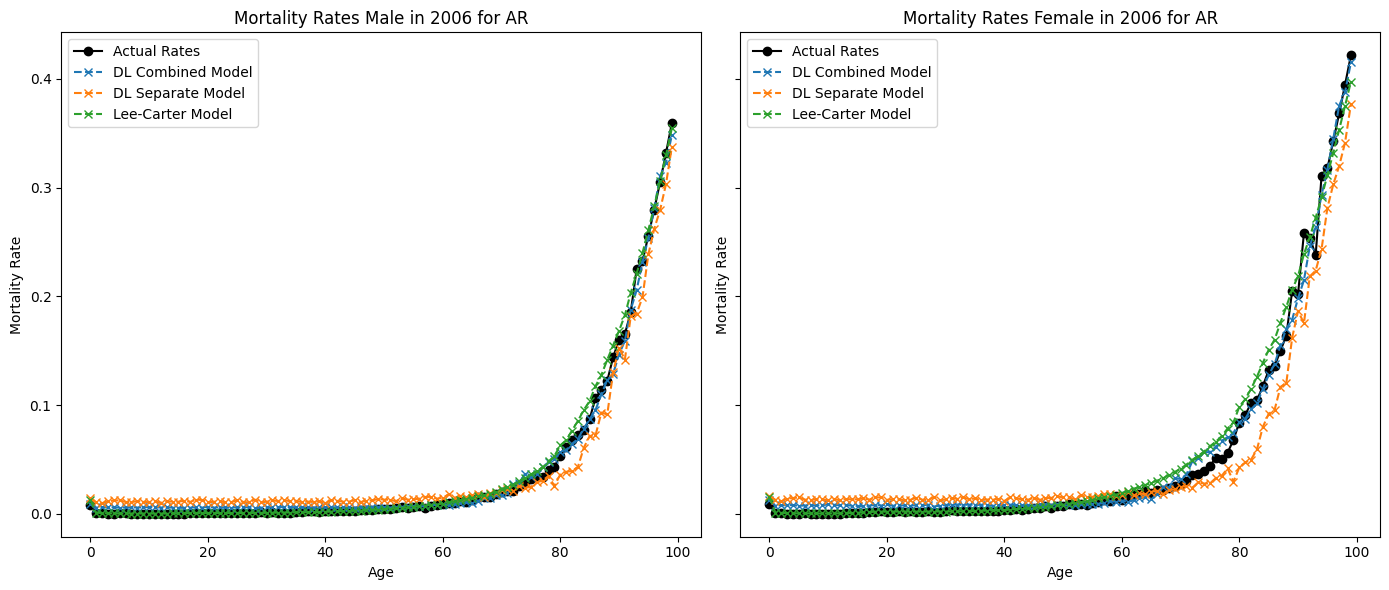

In [325]:
plot_mort_predictions(geo=3, year= 2006, age_range=np.arange(0,100), genders=[0,1], data=test_data, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_country
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

#### Plot difference from actual rates by age 

In [327]:
def plot_pred_diff_by_age(geo, year, age_range, genders, data, dl_models, model_names, lc_predictions, geos_key):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    axes = axes.flatten()

    for idx, gender in enumerate(genders):
        # Filter the actual data for the specific state, year, and gender
        actual_data = data[(data[:, 0] == geo) & (data[:, 2] == year) & (data[:, 1] == gender)]
        ages = actual_data[:, 3]  # Age column
        actual_rates = actual_data[:, 4]  # Mortality rate column

        # Prepare the plot
        ax = axes[idx]
        ax.axhline(y=0, color='black', linestyle='-', label='Actual Rates')

        # Generate predictions from each model
        for model_name in model_names:
            if model_name == 'Lee-Carter':
                # Filter predictions for the specific geo and gender
                lc_pred = lc_predictions[(lc_predictions[:, 0] == geo) & 
                                        (lc_predictions[:, 1] == gender) &
                                        (lc_predictions[:, 2] == year)]
               
                lc_diff = lc_pred[:, 4] - actual_rates

                # Plot Lee-Carter predictions
                ax.plot(age_range, lc_diff, label='Lee-Carter Model Difference', linestyle='--', marker='x')

            else:
                # DL models
                model = dl_models[model_name]
                predictions = []

                for age in age_range:
                    input_features = (tf.convert_to_tensor([(year - 1959) / 60], dtype=tf.float32),  # Normalized year
                                  tf.convert_to_tensor([age], dtype=tf.float32),  # Age
                                  tf.convert_to_tensor([geo], dtype=tf.float32),  # Geography
                                  tf.convert_to_tensor([gender], dtype=tf.float32))  # Gender
                    # Predict using the model
                    pred = model.predict(input_features)
                    predictions.append(pred[0][0])  # Append predicted rate

                dl_diff = np.array(predictions) - actual_rates 

                # Plot model predictions
                ax.plot(age_range, dl_diff, label=f'{model_name} Model Differences', linestyle='--', marker='x')

        # Title and labels
        ax.set_title(f'Difference in Predictions vs Actual: {"Male" if gender == 0 else "Female"} in {year} for {geos_key[geo]}')
        ax.set_xlabel('Age')
        ax.set_ylabel('Differnce in Mortality Rate')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

In [343]:
def plot_pred_diff_by_year(geo, year_range, age, genders, data, dl_models, model_names, lc_predictions, geos_key):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    axes = axes.flatten()

    for idx, gender in enumerate(genders):
        # Filter the actual data for the specific state, year, and gender
        actual_data = data[(data[:, 0] == geo) & (data[:, 3] == age) & (data[:, 1] == gender)]
        actual_rates = actual_data[:, 4]  # Mortality rate column

        # Prepare the plot
        ax = axes[idx]
        ax.axhline(y=0, color='black', linestyle='-', label='Actual Rates')

        # Generate predictions from each model
        for model_name in model_names:
            if model_name == 'Lee-Carter':
                # Filter predictions for the specific geo and gender
                lc_pred = lc_predictions[(lc_predictions[:, 0] == geo) & 
                                        (lc_predictions[:, 1] == gender) &
                                        (lc_predictions[:, 3] == age)]
               
                lc_diff = lc_pred[:, 4] - actual_rates

                # Plot Lee-Carter predictions
                ax.plot(year_range, lc_diff, label='Lee-Carter Model Difference', linestyle='--', marker='x')

            else:
                # DL models
                model = dl_models[model_name]
                predictions = []

                for year in year_range:
                    input_features = (tf.convert_to_tensor([(year - 1959) / 60], dtype=tf.float32),  # Normalized year
                                  tf.convert_to_tensor([age], dtype=tf.float32),  # Age
                                  tf.convert_to_tensor([geo], dtype=tf.float32),  # Geography
                                  tf.convert_to_tensor([gender], dtype=tf.float32))  # Gender
                    # Predict using the model
                    pred = model.predict(input_features)
                    predictions.append(pred[0][0])  # Append predicted rate

                dl_diff = np.array(predictions) - actual_rates 

                # Plot model predictions
                ax.plot( year_range, dl_diff, label=f'{model_name} Model Differences', linestyle='--', marker='x')

        # Title and labels
        ax.set_title(f'Difference in Predictions vs Actual: {"Male" if gender == 0 else "Female"} for {age} for {geos_key[geo]}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Difference in Mortality Rate')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

In [348]:
geos_key

array([['AK', '0'],
       ['AL', '1'],
       ['AZ', '2'],
       ['AR', '3'],
       ['CA', '4'],
       ['CO', '5'],
       ['CT', '6'],
       ['DE', '7'],
       ['FL', '8'],
       ['GA', '9'],
       ['HI', '10'],
       ['ID', '11'],
       ['IL', '12'],
       ['IN', '13'],
       ['IA', '14'],
       ['KS', '15'],
       ['KY', '16'],
       ['LA', '17'],
       ['ME', '18'],
       ['MD', '19'],
       ['MA', '20'],
       ['MI', '21'],
       ['MN', '22'],
       ['MS', '23'],
       ['MO', '24'],
       ['MT', '25'],
       ['NE', '26'],
       ['NV', '27'],
       ['NH', '28'],
       ['NJ', '29'],
       ['NM', '30'],
       ['NY', '31'],
       ['NC', '32'],
       ['ND', '33'],
       ['OH', '34'],
       ['OK', '35'],
       ['OR', '36'],
       ['PA', '37'],
       ['RI', '38'],
       ['SC', '39'],
       ['SD', '40'],
       ['TN', '41'],
       ['TX', '42'],
       ['UT', '43'],
       ['VT', '44'],
       ['VA', '45'],
       ['WA', '46'],
       ['WV', '47'],
  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

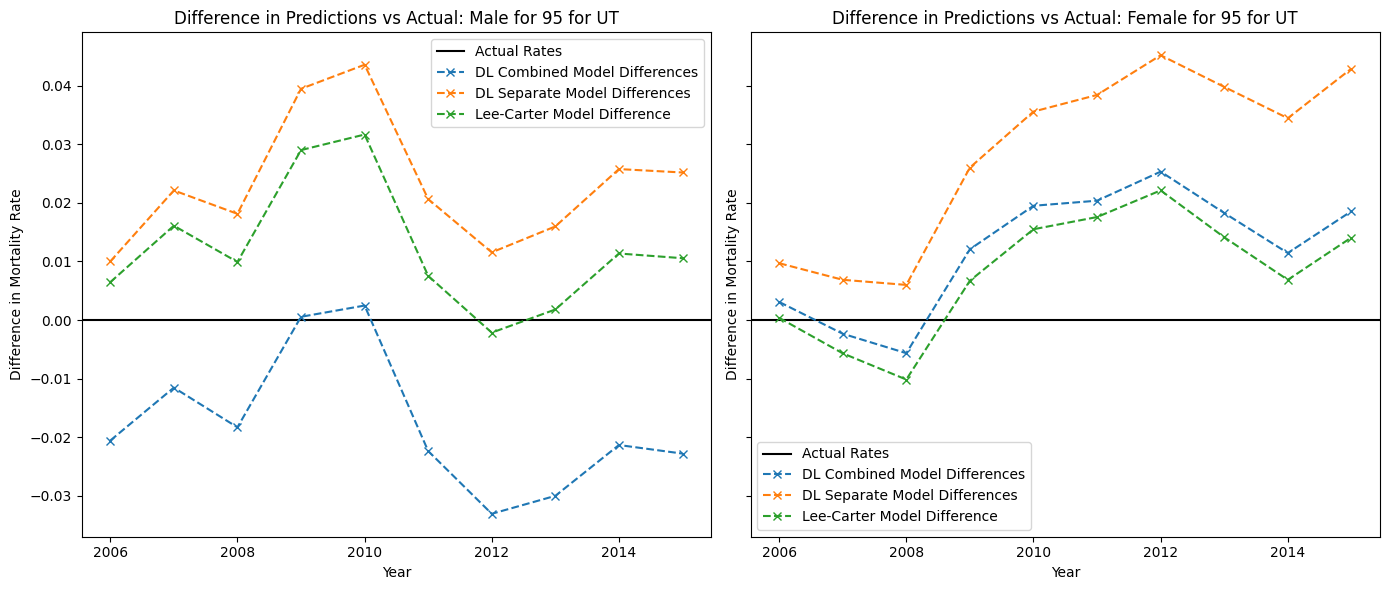

In [349]:
plot_pred_diff_by_year(geo=43, year_range=np.arange(2006, 2016), age=95, genders=[0,1], data=test_data, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_state
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

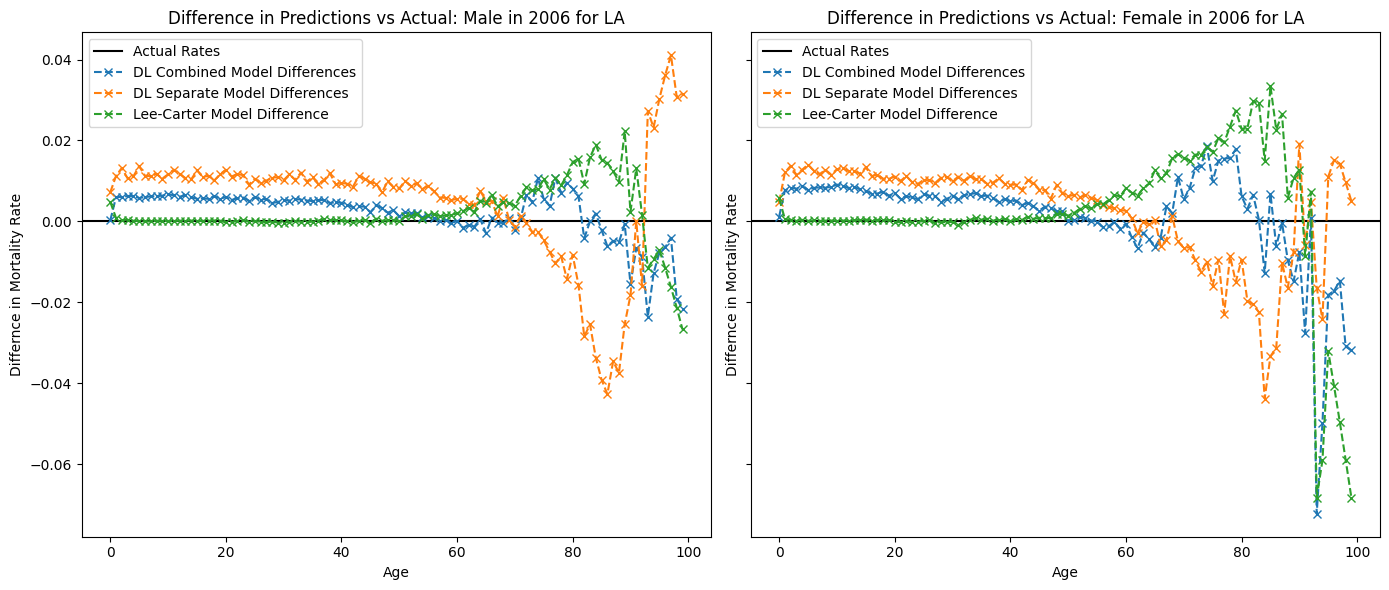

In [338]:
plot_pred_diff_by_age(geo=17, year= 2006, age_range=np.arange(0,100), genders=[0,1], data=test_data, 
                      dl_models={
                          'DL Combined': model_combined,
                          'DL Separate': model_state
                      }, model_names=['DL Combined','DL Separate', 'Lee-Carter'], lc_predictions=lc_predictions, geos_key=geos_list)

In [334]:
geos_key

array([['AK', '0'],
       ['AL', '1'],
       ['AZ', '2'],
       ['AR', '3'],
       ['CA', '4'],
       ['CO', '5'],
       ['CT', '6'],
       ['DE', '7'],
       ['FL', '8'],
       ['GA', '9'],
       ['HI', '10'],
       ['ID', '11'],
       ['IL', '12'],
       ['IN', '13'],
       ['IA', '14'],
       ['KS', '15'],
       ['KY', '16'],
       ['LA', '17'],
       ['ME', '18'],
       ['MD', '19'],
       ['MA', '20'],
       ['MI', '21'],
       ['MN', '22'],
       ['MS', '23'],
       ['MO', '24'],
       ['MT', '25'],
       ['NE', '26'],
       ['NV', '27'],
       ['NH', '28'],
       ['NJ', '29'],
       ['NM', '30'],
       ['NY', '31'],
       ['NC', '32'],
       ['ND', '33'],
       ['OH', '34'],
       ['OK', '35'],
       ['OR', '36'],
       ['PA', '37'],
       ['RI', '38'],
       ['SC', '39'],
       ['SD', '40'],
       ['TN', '41'],
       ['TX', '42'],
       ['UT', '43'],
       ['VT', '44'],
       ['VA', '45'],
       ['WA', '46'],
       ['WV', '47'],
  

#### Generate State MSE Barplot

In [ ]:
def calculate_mse_by_geo(data, model):
    mse_results = {}

    geo_data = {}
    for batch in data.as_numpy_iterator():